In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage 
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode,tools_condition


In [2]:
class State(TypedDict):
    messages : Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192")

In [5]:
api_key_tavily = os.getenv("TAVILY_API_KEY")
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("Who is the Indian Prime Minister")

{'query': 'Who is the Indian Prime Minister',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Know the PM - Prime Minister of India',
   'url': 'https://www.pmindia.gov.in/en/pms-profile/',
   'content': 'Image 9: PM IndiaShri Narendra Modi was sworn-in as India’s Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary elections. The first ever Prime Minister to be born after Independence, Shri Modi has previously served as the Prime Minister of India from 2014 to 2019, and from 2019 to 2024. Leading international agencies have noted that under the leadership of PM Narendra Modi, India has been eliminating poverty at record pace. Shri Modi believes that no Indian should be homeless and to realise this vision, over 4.2 crore houses were sanctionedunder the PM Awas Yojana between 2014 and 2024. PM Modi launched the ‘Make in India’ initiative to turn India into an international manufacturing pow

In [6]:
def multiply(a:int,b:int) -> int:
    """Multiply a and b

    Args:
        a (int) : first int
        b (int) : second int
    
    Returns:
        int : output int    
    """
    return a*b

In [7]:
tools = [tool,multiply]
tools

[TavilySearch(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 <function __main__.multiply(a: int, b: int) -> int>]

In [8]:
llm_with_tools = llm.bind_tools(tools)

In [9]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7e040ac9d760>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7e040ac9f560>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of doma

In [10]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder = StateGraph(State)

In [11]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [12]:
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))

In [13]:
graph_builder.add_edge(START,"tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",tools_condition
)
graph_builder.add_edge("tools","tool_calling_llm")


In [14]:
graph = graph_builder.compile()

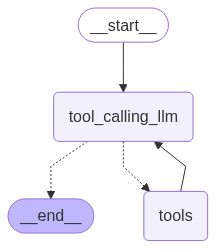

In [15]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
response = graph.invoke({"messages":"Who is the PM of India"})

In [18]:
response["messages"]

[HumanMessage(content='Who is the PM of India', additional_kwargs={}, response_metadata={}, id='79cdb45c-0dea-48d8-8bb0-a7136488c60e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6n9hy7233', 'function': {'arguments': '{"query":"Who is the PM of India","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 2194, 'total_tokens': 2250, 'completion_time': 0.268224928, 'prompt_time': 0.077663728, 'queue_time': 0.057288712000000006, 'total_time': 0.345888656}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3ec18732-9821-46af-8601-256f97fd10c0-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Who is the PM of India', 'topic': 'news'}, 'id': '6n9hy7233', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2194, 'output_tokens': 56, 'total_tokens': 2250}),
 ToolMessage(content='{"query": "

In [19]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who is the PM of India
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6n9hy7233)
 Call ID: 6n9hy7233
  Args:
    query: Who is the PM of India
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Who is the PM of India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ddnews.gov.in/en/axiom-mission-4-set-to-take-off-on-june-25-from-kennedy-space-centre/", "title": "NASA targets June 25 for Axiom-4 launch after multiple delays - DD News", "score": 0.4787, "published_date": "Tue, 24 Jun 2025 10:01:12 GMT", "content": "Image 5: DD News Image 15: NASA targets June 25 for Axiom-4 launch after multiple delays NASA has set June 25 as the new launch date for the long-delayed Axiom-4 (Ax-4) mission to the International Space Station (ISS)

In [59]:
response2 = graph.invoke({"messages":"What is the 5 multiplied by 6"})

In [60]:
response2

{'messages': [HumanMessage(content='What is the 5 multiplied by 6', additional_kwargs={}, response_metadata={}, id='583f12db-98f7-4e7b-a1f5-795ee000ff19'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 't9ack1dzj', 'function': {'arguments': '{"a":5,"b":6}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 2197, 'total_tokens': 2245, 'completion_time': 0.165913305, 'prompt_time': 0.093228173, 'queue_time': 0.05595350700000001, 'total_time': 0.259141478}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cf5334cb-c1c5-4ea6-8d3b-1bc7755ea8a7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 6}, 'id': 't9ack1dzj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2197, 'output_tokens': 48, 'total_tokens': 2245}),
  ToolMessage(content='30', name='multiply', id='e2bb823d-1994-4d7a-b89b-17de28ae5daf', tool_ca

In [61]:
for m in response2["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the 5 multiplied by 6
================================== Ai Message ==================================
Tool Calls:
  multiply (t9ack1dzj)
 Call ID: t9ack1dzj
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30
